# Supervised Text Classification of Sarcastic Comments in Python

Abhiram Tirumala, Rohith Sudhakar, Satvik Katla, Nevin Gilbert

### Objective

In this Notebook, we explore Supervised text classification for the purposes of being able to develop a Machine Learning model to detect sarcasm in natural language. We explore usages of BERT and LSTM Neural Networks.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import os
import re

import sklearn
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split

!pip install eli5
import eli5

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

     |████████████████████████████████| 112kB 15.8MB/s 


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

## Dataset Preprocessing
The dataset we will use is a compilation of both sarcastic and not sarcastic comments scraped from Reddit. This dataset was published under Kaggle and can be found here:

https://www.kaggle.com/sachinichake/detect-sarcasm-in-comments?select=Train.csv

Here we fetch the dataset from our public GitHub repository and store it as a Pandas DataFrame.

In [ ]:
!wget https://raw.githubusercontent.com/abhitirumala/CS4641-Term-Project/master/datasets/detect_sarcasm_in_comments/Train.csv
!wget https://raw.githubusercontent.com/abhitirumala/CS4641-Term-Project/master/datasets/detect_sarcasm_in_comments/Test.csv
df = pd.read_csv('Train.csv')
df

--2020-12-03 04:08:03--  https://raw.githubusercontent.com/abhitirumala/CS4641-Term-Project/master/datasets/detect_sarcasm_in_comments/Train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3647830 (3.5M) [text/plain]
Saving to: ‘Train.csv’

Train.csv           100%[===================>]   3.48M  --.-KB/s    in 0.06s   

2020-12-03 04:08:04 (61.3 MB/s) - ‘Train.csv’ saved [3647830/3647830]

--2020-12-03 04:08:04--  https://raw.githubusercontent.com/abhitirumala/CS4641-Term-Project/master/datasets/detect_sarcasm_in_comments/Test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request

,ID,comment,date,down,parent_comment,score,top,topic,user,label
0,uid_590555,"Well, let's be honest here, they don't actuall...",2015-04,0,They should shut the fuck up and let the commu...,2,2,starcitizen,Combat_Wombatz,0
1,uid_671762,"Well, I didn't need evidence to believe in com...",2016-12,-1,You need evidence to kill people? I thought we...,6,-1,EnoughCommieSpam,starkadd,1
2,uid_519689,"Who does an ""official promo"" in 360p?",2013-11,0,2014 BMW S1000R: Official Promo,3,3,motorcycles,phybere,0
3,uid_788362,Grotto koth was the best,2015-09,0,Not really that memorable lol if you want memo...,2,2,hcfactions,m0xyMC,1
4,uid_299252,Neal's back baby,2015-11,0,James Neal hit on Zach Parise,-5,-5,hockey,Somuch101,1
...,...,...,...,...,...,...,...,...,...,...
14995,uid_845344,Well with a name like El Cubano I'm surprised ...,2015-01,0,There's two things you don't do in Florida. - ...,18,18,hockey,shutupisaac,0
14996,uid_757880,... This is a good point.,2014-04,0,Sounds like a pretty good overall summary of o...,6,6,hockey,em483,0
14997,uid_724706,Yep.,2015-09,0,"I know the type you speak of. The ""die cis scu...",2,2,AskReddit,YoImAli,0
14998,uid_1006984,That's what the government WANTS you to believe!,2016-01,0,That there's A hidden cure for cancer but phar...,1,1,AskReddit,OhHiGCHQ,1


Since no direct correlation between score and the label exists, we can drop it as an unecessary feature. Similarly, we drop the User ID, comment date, no. of downvotes, top, username, score, and topic as they are irrelevant features and/or are too difficult to accurately incorporate in the model.

In [ ]:
df = df.drop(columns=['ID', 'date', 'down', 'top', 'user', 'score', 'topic'])
df

,comment,parent_comment,label
0,"Well, let's be honest here, they don't actuall...",They should shut the fuck up and let the commu...,0
1,"Well, I didn't need evidence to believe in com...",You need evidence to kill people? I thought we...,1
2,"Who does an ""official promo"" in 360p?",2014 BMW S1000R: Official Promo,0
3,Grotto koth was the best,Not really that memorable lol if you want memo...,1
4,Neal's back baby,James Neal hit on Zach Parise,1
...,...,...,...
14995,Well with a name like El Cubano I'm surprised ...,There's two things you don't do in Florida. - ...,0
14996,... This is a good point.,Sounds like a pretty good overall summary of o...,0
14997,Yep.,"I know the type you speak of. The ""die cis scu...",0
14998,That's what the government WANTS you to believe!,That there's A hidden cure for cancer but phar...,1


### Text Preprocessing
Here we define a function to get rid of punctuation in each comment. punctuation is often too difficult to incorporate in a model since they are often used in varying ways. Stop words are defined as words that contribute very little to the meaning and sentiment of a sentence, and can be removed in  order to save on computation power. We also lemmatize each comment de depluralize words so they are treated the same.



In [ ]:
text = df['comment'].sample(1).values[0]
# text = "Yay! That's amazing!"
print('\nOriginal: ', text)

stemmer = WordNetLemmatizer()

def clean_string(text):
    # nopunc = [char.lower() for char in text if char not in string.punctuation]
    x = []
    for char in text.lower():
      if char in string.punctuation:
        x.append(" " + char + " ")
      else:
        x.append(char)
    nopunc = x
    nopunc = ''.join(nopunc)
    nopunc =  [word.lower() for word in nopunc.split()]# if word not in stopwords.words('english')]
    nopunc = [stemmer.lemmatize(word) for word in nopunc]
    if nopunc == []:
      return None
    return ' '.join(nopunc)

print('Modified: ', clean_string(text))


Original:  You should put them in a usb flash drive on your keychain.
Modified:  you should put them in a usb flash drive on your keychain .


In [ ]:
df['comment'] = df['comment'].apply(clean_string)
df['parent_comment'] = df['parent_comment'].apply(clean_string)
# df['comment'] = df['comment'].apply(lambda x: x.lower())
# df['comment'] = df['comment'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
# df['parent_comment'] = df['parent_comment'].apply(lambda x: x.lower())
# df['parent_comment'] = df['parent_comment'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
df = df.dropna()
# df.head()

## Supervised Machine Learning Model

In order to prepare the data further to train our machine learner, we split the data into train and test (validation) sets.

In [ ]:
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(df[['comment', 'parent_comment']], y, test_size=0.2)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
X_test.head()

(12000, 2) (12000,)
(3000, 2) (3000,)


,comment,parent_comment
13222,it ' s a tourist trap city with sewage running...,"venice , italy . i wa only there one day while..."
7055,unfortunately i don ' t use facebook,join some facebook group and such .
2471,i thought it wa all satire,and people on here were really saying that jos...
13801,"the screen us a little more power , but the ma...",bigger screen also mean more battery usage . h...
14850,so pee on them both ; dominance established .,they ' re just trying to establish dominance .


### Model Architecture

In order to classify comments as sarcastic or not sarcastic, we use Logistic Regression to classify the comments. Each comment and parent comment will be transformed into a vector representing different n-grams (short phrases of words) found in the text data.

We use the scikit-learn implementation of Logistic Regression and TF-IDF Vectorization.

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

Our model is constructed as a pipline as such:

1.   Input: (cleaned comment, cleaned parent comment)
2.   TF-IDF Vectorization
3.   Logitic Regression: concatentated input of comment vector and parent comment vector
4.   Output: integer representing whether or not the comment was sarcastic

Our intention is that the parent comment can act as a contextual phrase for which the model can base its prediction off, and make a more accurate prediction on the comment's sarcasm. This addition in our testing has improved the model accuracy by about 3%.

In [ ]:
# build bigrams, put a limit on maximal number of features
# and minimal word frequency
tf_idf_comment = TfidfVectorizer(ngram_range=(1, 3), max_features=100000, min_df=2,
                         token_pattern='\S+')
tf_idf_parent = TfidfVectorizer(ngram_range=(1, 2), max_features=10000, min_df=3,
                         token_pattern='\S+')
# multinomial logistic regression a.k.a softmax classifier
logit = LogisticRegression(C=0.1, n_jobs=4, solver='lbfgs', max_iter=1000, verbose=1)

def fn(x):
    if isinstance(x, list): x = x[0]
    return x['comment']

def fn2(x):
    if isinstance(x, list): x = x[0]
    return x['parent_comment']

transformer = FeatureUnion([('tf_idf_comment', 
                            Pipeline([('extract_field', FunctionTransformer(fn, validate=False)),
                                        ('tfidf', tf_idf_comment)])),
                            ('tf_idf_parent', 
                            Pipeline([('extract_field', FunctionTransformer(fn2, validate=False)),
                                        ('tfidf', tf_idf_parent)]))])

tfidf_logit_pipeline = Pipeline([('transformer', transformer), 
                                 ('logit', logit)])

tfidf_logit_pipeline.fit(X_train, y_train)
pred = tfidf_logit_pipeline.predict(X_test)
print('-- Completed training on Reply Comments --')
print('Accuracy:', sklearn.metrics.accuracy_score(y_test, pred))

[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done   1 out of   1 | elapsed:    1.2s finished


-- Completed training on Reply Comments --
Accuracy: 0.6563333333333333


From the accuracy on validation data noted above, we find that after training the model accuracy is about 65-68%. While this number is quite low, it is quite impressive considering how difficult it is to pick up verbal sarcasm as humans, even with contextual words and phrases.

We find that our model was able to pick up interesting patterns in how humans use sarcasm.

### Model Analysis

To further understand what exactly ocurred when fitting the Logistic Regression model on our train data, we use the ELI5 library to visualize how exactly the model determines sarcasm in text.

As we can see in the code block below, each n-gram is assigned a weight that is trained over many iterations, and we find that the usage som some words and punctuation tend to be more indicative of sarcasm than others.

We find that the usage of "because", "yeah", "!", and other phrases in a comment contribute more to the sarcastic nature of a comment. 

In [ ]:
from eli5.sklearn.explain_weights import explain_linear_classifier_weights

transformer = tfidf_logit_pipeline.named_steps['transformer']

tf_idf_texts = transformer.transformer_list[0][1].named_steps['tfidf']
tf_idf_subreddits = transformer.transformer_list[1][1].named_steps['tfidf']

feature_names = tf_idf_texts.get_feature_names() + tf_idf_subreddits.get_feature_names()

explain_linear_classifier_weights(clf=tfidf_logit_pipeline.named_steps['logit'],
                                  feature_names=feature_names, top=(30, 0))

Weight?,Feature
+1.367,because
+1.294,!
+1.285,yeah
+0.968,forgot
+0.808,all
+0.700,"yeah ,"
+0.662,obviously
+0.615,forgot the
+0.604,totally
+0.596,well


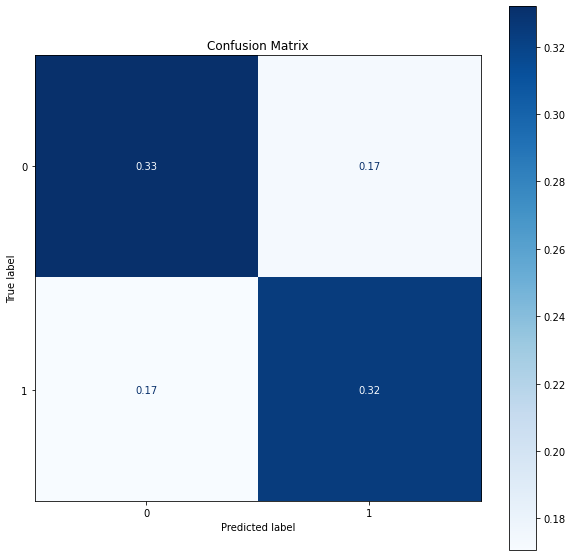

In [ ]:
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(10, 10))
plot_confusion_matrix(tfidf_logit_pipeline, X_test, y_test,
                                 cmap=plt.cm.Blues, normalize='all', ax=ax)
plt.title("Confusion Matrix")
plt.show()

## Model Testing on Your Own Comments

Our initial goal for this term project was to eventually develop a machine learning model that can detect sarcastic comments in the real world. Hence, we built a simple pipeline to write our own comments and evaluate them to see if they are sarcastic.

In [ ]:
test_df = pd.read_csv('Test.csv')

Using the code block below, we can write our own strings of text and apply our model pipeline to see if it is sarcastic.


---


**Example**

When using the following strings in our model, we found some interesting results.

*   COMMENT: "Russell Wilson is the undisputed MVP in the NFL"
*   CONTEXTUAL_COMMENT: "The Seahawks are 7-3 with Wilson as the QB"

We find that our model notes this as sarcastic. However, when we replace the name of the football player with another notable person ("Patrick Mahomes", "Tom Brady", "Lamar Jackson"), we find the the model predicts these statement as not sarcastic. Perhaps in our training data, the model identified some prejudice against Russell Wilson?

Similar to before, we can visualize our prediction with a table, wher each n-gram is recorded along with its respective contribution the the aggregated prediction.


---


**Please feel free to try our model with your own comments and phrases!**

In [ ]:

COMMENT = "lamar jackson is the undisputed MVP in the NFL"
CONTEXTUAL_COMMENT = "The Seahawks are 7-3 with Wilson as the QB"
TRUTH_LABEL = 1

test_df = test_df[['comment', 'parent_comment']]
text_to_predict, context, label = COMMENT, CONTEXTUAL_COMMENT, TRUTH_LABEL

print("Raw Text:", text_to_predict)
text_to_predict = clean_string(text_to_predict)
print("Text:", text_to_predict)
print("\nRaw Context:", context)
context = clean_string(context)
print("Context:", context)
print("\nActual Label:", label)

test_df = test_df.append({
     "comment": text_to_predict,
     "parent_comment":  context
      }, ignore_index=True)
print("Predicted Label:", tfidf_logit_pipeline.predict(test_df)[-1])
eli5.explain_prediction(tfidf_logit_pipeline.named_steps['logit'], test_df.tail(1),
                        vec=transformer, feature_names=(tf_idf_texts.get_feature_names()+tf_idf_parent.get_feature_names()),
                        target_names=label)

Raw Text: lamar jackson is the undisputed MVP in the NFL
Text: lamar jackson is the undisputed mvp in the nfl

Raw Context: The Seahawks are 7-3 with Wilson as the QB
Context: the seahawks are 7 - 3 with wilson a the qb

Actual Label: 1
Predicted Label: 0


Explanation(estimator="LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,\n                   intercept_scaling=1, l1_ratio=None, max_iter=1000,\n                   multi_class='auto', n_jobs=4, penalty='l2',\n                   random_state=None, solver='lbfgs', tol=0.0001, verbose=1,\n                   warm_start=False)", description=None, error=None, method='linear model', is_regression=False, targets=[TargetExplanation(target=0, feature_weights=FeatureWeights(pos=[FeatureWeight(feature='in', weight=0.05062584157969316, std=None, value=0.1622300033290998), FeatureWeight(feature='the', weight=0.038756341792505145, std=None, value=0.22395311527333012), FeatureWeight(feature='in the', weight=0.037123832582611226, std=None, value=0.2251683781783334), FeatureWeight(feature='is', weight=0.0228186546072058, std=None, value=0.1484524861932136), FeatureWeight(feature='is the', weight=0.02226677565400349, std=None, value=0.2827028040484238), FeatureWeight(feature='seahawks', weight=0.017873246014451213, std=None, value=0.39056033979834903), FeatureWeight(feature='- 3', weight=0.014185817568110584, std=None, value=0.34689081836336877), FeatureWeight(feature='7', weight=0.010320464961379675, std=None, value=0.2699745388518487), FeatureWeight(feature='7 -', weight=0.00519329014422039, std=None, value=0.3789401948289814), FeatureWeight(feature='mvp', weight=0.004988036306678852, std=None, value=0.46664491055919516), FeatureWeight(feature='the', weight=0.003369507141256483, std=None, value=0.17076202498248333)], neg=[FeatureWeight(feature='are', weight=-0.033509452999425204, std=None, value=0.14715842726561945), FeatureWeight(feature='<BIAS>', weight=-0.030489182473791048, std=None, value=1.0), FeatureWeight(feature='-', weight=-0.0232436862690336, std=None, value=0.1501949555291427), FeatureWeight(feature='qb', weight=-0.020843781527694023, std=None, value=0.3740685904632234), FeatureWeight(feature='with', weight=-0.018696957942888566, std=None, value=0.14266771932753528), FeatureWeight(feature='3', weight=-0.01857784665557101, std=None, value=0.22542121598010986), FeatureWeight(feature='the nfl', weight=-0.015268767986375512, std=None, value=0.41739889906735556), FeatureWeight(feature='a the', weight=-0.010632856845845426, std=None, value=0.2719635541833396), FeatureWeight(feature='nfl', weight=-0.010489229383685572, std=None, value=0.40140979999213144), FeatureWeight(feature='a', weight=-0.010143482437607376, std=None, value=0.09283158128789389), FeatureWeight(feature='wilson', weight=-0.009334193129490256, std=None, value=0.3789401948289814), FeatureWeight(feature='jackson', weight=-0.004650666487053344, std=None, value=0.46664491055919516)], pos_remaining=0, neg_remaining=0), proba=0.5054102148928594, score=-0.02164170421365508, weighted_spans=None, heatmap=None)], feature_importances=None, decision_tree=None, highlight_spaces=None, transition_features=None, image=None)